In [3]:
import earthaccess
import xarray as xr
auth = earthaccess.login()
if not auth.authenticated:
    auth.login(strategy="interactive", persist=True)

results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_LANDVI",
    temporal = ("2024-09-01", "2024-09-30"),
    granule_name="*.MO.*.4km.*"
)
fileset = earthaccess.open(results);

# Load relevant datasets
dataset = xr.open_dataset(fileset[0])
latitude = dataset["lat"]
longitude = dataset["lon"]
ndvi = dataset["ndvi"]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
import earthaccess
import xarray as xr
auth = earthaccess.login()
if not auth.authenticated:
    auth.login(strategy="interactive", persist=True)

results1 = earthaccess.search_data(
    short_name = "PACE_OCI_L4M_MOANA",
    temporal = ("2024-09-01", "2024-09-30"),
    granule_name="*.MO.*.4km.*"
)

# Load the data
fileset1 = earthaccess.open(results1)
ds1 = xr.open_dataset(fileset1[0])
ds1

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 213MB
Dimensions:          (lat: 3360, lon: 2640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 13kB 69.98 69.94 69.9 ... -69.9 -69.94 -69.98
  * lon              (lon) float32 11kB -84.98 -84.94 -84.9 ... 24.9 24.94 24.98
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (lat, lon) float64 71MB ...
    syncoccus_moana  (lat, lon) float64 71MB ...
    picoeuk_moana    (lat, lon) float64 71MB ...
    palette          (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/62)
    product_name:                      PACE_OCI.20240901_20240930.L4m.MO.MOAN...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L4M/MOANA/3.1
    data_bins:                         4362999
    data_minimum:                      0.0
    data_maximum:                      6.2898012e+10

In [8]:
# Load Libraries for printing
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gc

In [9]:
# Stack into RGB: R=Micro, G=Pico, B=Nano (or whatever mapping you prefer)
R = ds1["syncoccus_moana"].values
G = ds1["picoeuk_moana"].values
B = ds1["prococcus_moana"].values

rgb_image = np.stack([R, G, B], axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2147483648.0..2147483647.0].


Text(0.5, 1.0, 'Phytoplankton Size-Class RGB')

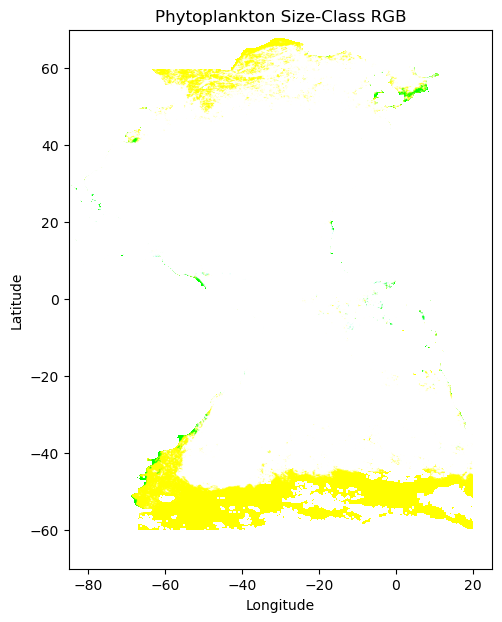

In [10]:
plt.figure(figsize=(10,7))
plt.imshow(rgb_image, extent=[
    ds1.lon.min(), ds1.lon.max(),
    ds1.lat.min(), ds1.lat.max()
])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Phytoplankton Size-Class RGB")
#plt.show()

In [14]:
import earthaccess
import xarray as xr
auth = earthaccess.login()
if not auth.authenticated:
    auth.login(strategy="interactive", persist=True)

results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = ("2024-06-01", "2024-06-30"),
    granule_name="*.MO.*.4km.*"
)
fileset = earthaccess.open(results);

# Load relevant datasets
dataset = xr.open_dataset(fileset[0])
latitude = dataset["lat"]
longitude = dataset["lon"]
CHL = dataset["chlor_a"]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# These constants are from Brewin et al. 2011, but other sets exist in the literature
Cpm  = 0.107    # asymptotic max pico chl (mg m^-3)
Cpmn = 0.775    # asymptotic max pico+nano chl (mg m^-3)
Sp   = 5.118     # slope pico
Spn  = 1.152     # slope pico+nano

Cp = Cpm * (1 - np.exp(-Sp * CHL))
Cpn = Cpmn * (1 - np.exp(-Spn * CHL))

Cn = Cpn - Cp
Cm = CHL - Cpn

# Putting this into a "dataset" so it's easier to handle moving forward
psc = xr.Dataset({"chl_pico": Cp, "chl_nano": Cn,"chl_micro": Cm}, coords=CHL.coords)

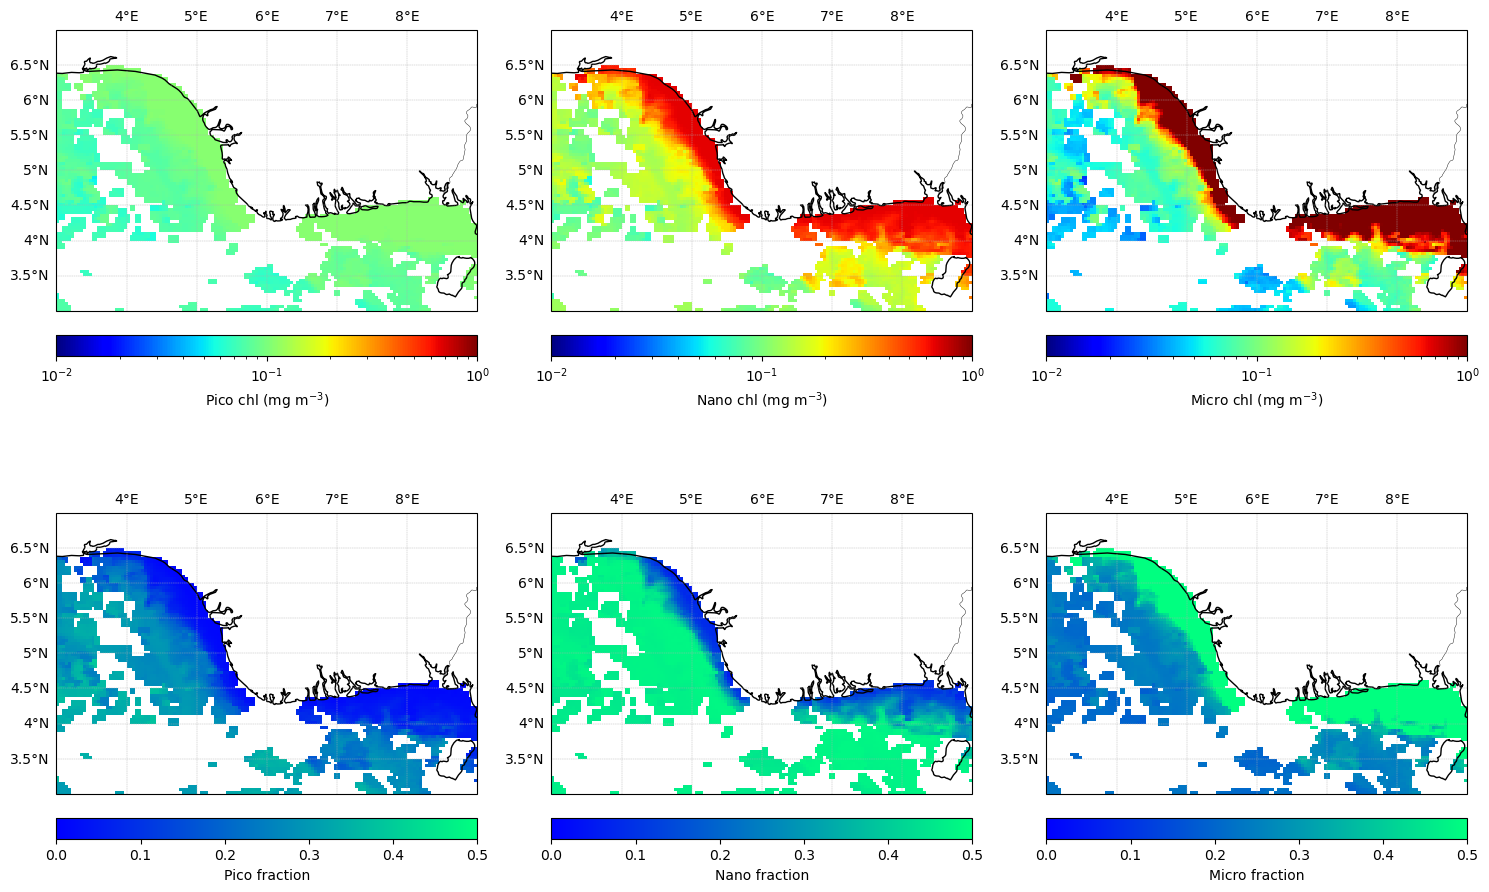

In [16]:
import matplotlib.colors as mcolors

lat_min, lat_max = 3, 7
lon_min, lon_max = 3, 9

psc_sub = psc.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
CHL_sub = CHL.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

# Compute fractions from the subset
psc_frac_sub = xr.Dataset({"chl_pico_frac": psc_sub["chl_pico"] / CHL_sub,
        "chl_nano_frac": psc_sub["chl_nano"] / CHL_sub,
        "chl_micro_frac": psc_sub["chl_micro"] / CHL_sub})

# Variables for plotting
abs_vars = ["chl_pico", "chl_nano", "chl_micro"]
frac_vars = ["chl_pico_frac", "chl_nano_frac", "chl_micro_frac"]
titles = ["Pico", "Nano", "Micro"]

fig, axs = plt.subplots(2, 3, figsize=(15, 10),subplot_kw={"projection": ccrs.PlateCarree()})

# Plot size-partitioned chlorophyll (top row)
for ax, var, title in zip(axs[0], abs_vars, titles):
    da = psc_sub[var]
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.set_title(f"{title} chlorophyll")
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    # Add lat/lon gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, linestyle="--")
    gl.top_labels = True
    gl.bottom_labels = False 
    gl.right_labels = False
    img = da.plot(ax=ax, x="lon", y="lat", cmap="jet", robust=True, add_colorbar=False, norm=mcolors.LogNorm(vmin=0.01, vmax=1))
    cbar = plt.colorbar(img, ax=ax, orientation="horizontal", pad=0.05)
    cbar.set_label(f"{title} chl (mg m$^{{-3}}$)")

# Plot fractions (bottom row)
for ax, var, title in zip(axs[1], frac_vars, titles):
    da = psc_frac_sub[var]
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.set_title(f"{title} fraction")
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    # Add lat/lon gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, linestyle="--")
    gl.top_labels = True
    gl.bottom_labels = False 
    gl.right_labels = False
    img = da.plot(ax=ax, x="lon", y="lat", cmap="winter", add_colorbar=False, vmin=0, vmax=0.5)
    cbar = plt.colorbar(img, ax=ax, orientation="horizontal", pad=0.05)
    cbar.set_label(f"{title} fraction")

plt.tight_layout()
plt.show()

In [17]:
# Stack into RGB: R=Micro, G=Pico, B=Nano (or whatever mapping you prefer)
R = psc_frac_sub["chl_micro_frac"].values
G = psc_frac_sub["chl_nano_frac"].values
B = psc_frac_sub["chl_pico_frac"].values

rgb_image = np.stack([R, G, B], axis=-1)

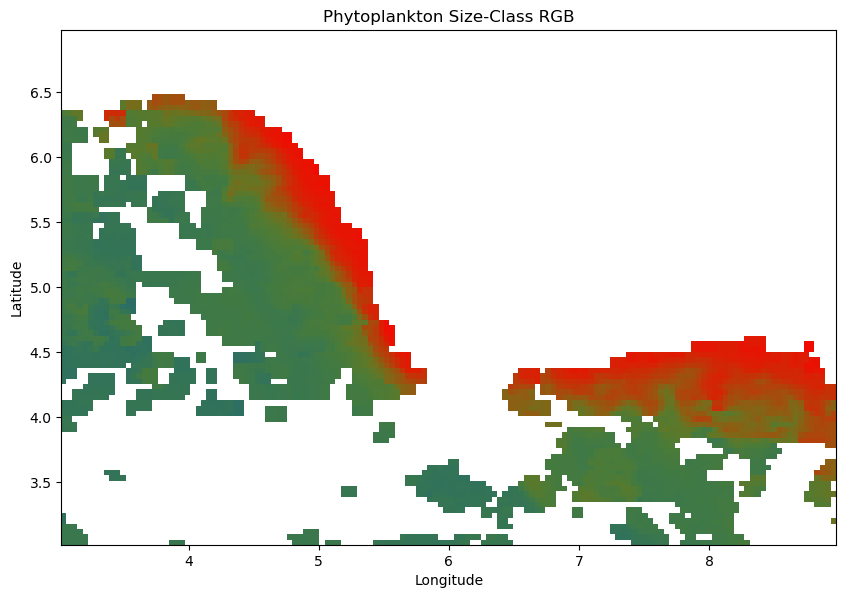

In [22]:
plt.figure(figsize=(10,7))
plt.imshow(rgb_image, extent=[
    psc_sub.lon.min(), psc_sub.lon.max(),
    psc_sub.lat.min(), psc_sub.lat.max()
])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Phytoplankton Size-Class RGB")

for ax, var, title in zip(axs[0], frac_vars, titles):
    ax.coastlines()
    
plt.show()

In [25]:
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_CHL',
    temporal = ("2024-01-01", "2025-12-31"), #use larger memory to avoid crash
    granule_name="*.MO.*.4km.*"
)
fileset = earthaccess.open(results)
ds = xr.open_dataset(fileset[1])

QUEUEING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/21 [00:00<?, ?it/s]

In [26]:
# We can open all the files but note there is no time coordinate so we need
# combine="nested" and concat_dim
ds = xr.open_mfdataset(
    fileset,
    combine="nested",
    concat_dim="time")
ds


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 21, lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time, rgb, eightbitcolor
Data variables:
    chlor_a  (time, lat, lon) float32 3GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (time, rgb, eightbitcolor) uint8 16kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.CHL....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.1
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         17997925
    data_minimum:                      0.0049575833
    data_maximum:                      98.117165

In [27]:
# Let's add the time coord since we will likely want to subset on time later
import pandas as pd
t = pd.date_range(start="2024-03-01", end="2025-11-30", freq="MS") #set to actual date, otherwise will result in an error
ds = ds.assign_coords(time=t)
ds

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 21, lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * time     (time) datetime64[ns] 168B 2024-03-01 2024-04-01 ... 2025-11-01
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (time, lat, lon) float32 3GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (time, rgb, eightbitcolor) uint8 16kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.CHL....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.1
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         17997925
    data_minimum:                      0.0049575833
    data_maximum:                      98.117165

/tmp/ipykernel_7438/2392581117.py:22: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in ndvi_plot.axes.flat:


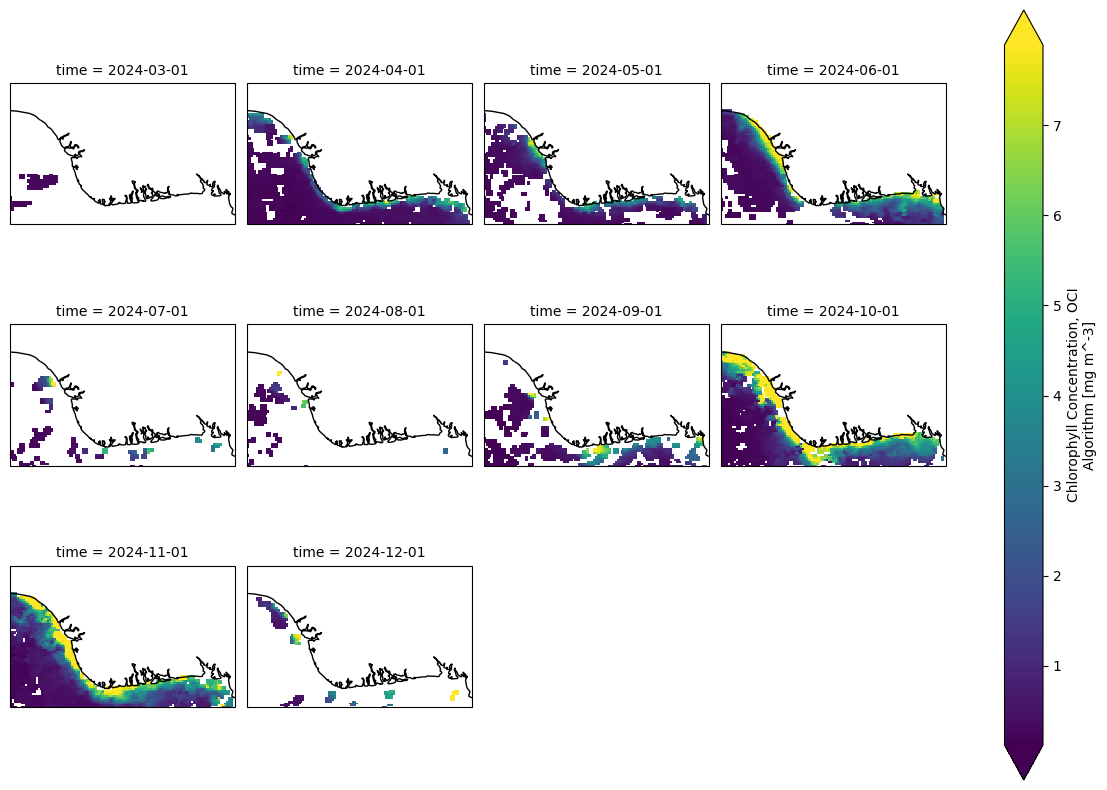

In [28]:







#caution, use larger memory to avoidcrash
import matplotlib.pyplot as plt

ndvi = ds["chlor_a"].sel(
    lat=slice(7, 3), 
    lon=slice(3, 9),
    time=slice("2024-03-01", "2024-12-30") #WHEN THIS CHANGED, ALSO CHANGE THE OUTPUT NAME BELOW
)

import cartopy.crs as ccrs
ndvi_plot=ndvi.plot(
    col="time",            # one panel per month
    col_wrap=4,            # 4 columns per row
    #vmin=0.7,
    #vmax=0.8,
    robust=True,           # ignore outliers for color scale
    figsize=(12, 8),
    subplot_kws={"projection": ccrs.PlateCarree()},
    transform=ccrs.PlateCarree()
)

for ax in ndvi_plot.axes.flat:
    ax.set_extent(
        [3.956111, 9.040000, 3.856667, 7.049167],
        crs=ccrs.PlateCarree()
    )
    ax.coastlines()

#plt.savefig("2024_timeseries2.png") #DONT FORGET TO CHANGE THIS

/tmp/ipykernel_7438/875676923.py:22: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in ndvi_plot.axes.flat:


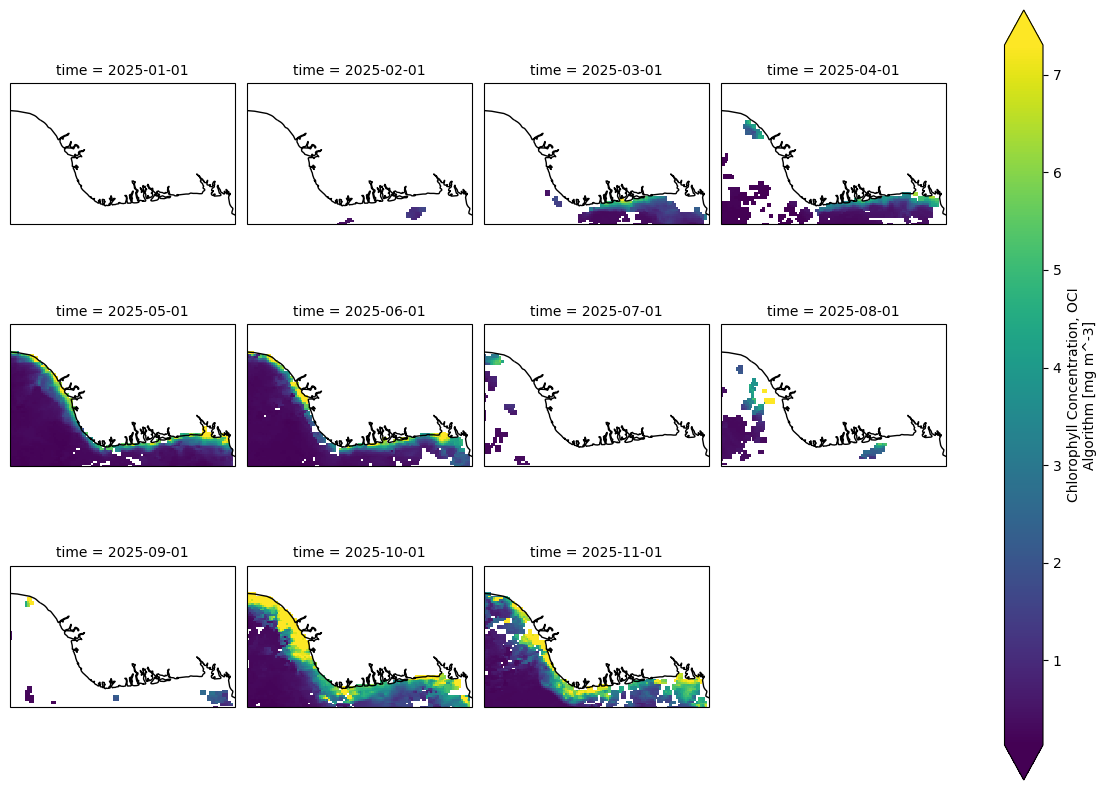

In [29]:







#caution, use larger memory to avoidcrash
import matplotlib.pyplot as plt

ndvi = ds["chlor_a"].sel(
    lat=slice(7, 3), 
    lon=slice(3, 9),
    time=slice("2025-01-01", "2025-12-30") #WHEN THIS CHANGED, ALSO CHANGE THE OUTPUT NAME BELOW
)

import cartopy.crs as ccrs
ndvi_plot=ndvi.plot(
    col="time",            # one panel per month
    col_wrap=4,            # 4 columns per row
    #vmin=0.7,
    #vmax=0.8,
    robust=True,           # ignore outliers for color scale
    figsize=(12, 8),
    subplot_kws={"projection": ccrs.PlateCarree()},
    transform=ccrs.PlateCarree()
)

for ax in ndvi_plot.axes.flat:
    ax.set_extent(
        [3.956111, 9.040000, 3.856667, 7.049167],
        crs=ccrs.PlateCarree()
    )
    ax.coastlines()

#plt.savefig("2024_timeseries2.png") #DONT FORGET TO CHANGE THIS

In [30]:
results1 = earthaccess.search_data(
    short_name = 'PACE_OCI_L4M_MOANA',
    temporal = ("2024-01-01", "2025-12-31"), #use larger memory to avoid crash
    granule_name="*.MO.*.4km.*"
)
fileset1 = earthaccess.open(results1)
ds1 = xr.open_dataset(fileset1[1])

QUEUEING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/21 [00:00<?, ?it/s]

In [31]:
# We can open all the files but note there is no time coordinate so we need
# combine="nested" and concat_dim
ds1 = xr.open_mfdataset(
    fileset1,
    combine="nested",
    concat_dim="time")
ds1

<xarray.Dataset> Size: 4GB
Dimensions:          (time: 21, lat: 3360, lon: 2640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 13kB 69.98 69.94 69.9 ... -69.9 -69.94 -69.98
  * lon              (lon) float32 11kB -84.98 -84.94 -84.9 ... 24.9 24.94 24.98
Dimensions without coordinates: time, rgb, eightbitcolor
Data variables:
    prococcus_moana  (time, lat, lon) float64 1GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (time, lat, lon) float64 1GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (time, lat, lon) float64 1GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (time, rgb, eightbitcolor) uint8 16kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240301_20240331.L4m.MO.MOAN...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L4M/MOANA/3.1
    data_bins:                         4152146
    data_minimum:                      0.0
    data_maximum:                      1.2604206e+12

In [32]:
# Let's add the time coord since we will likely want to subset on time later
import pandas as pd
t = pd.date_range(start="2024-03-01", end="2025-11-30", freq="MS") #set to actual date, otherwise will result in an error
ds1 = ds1.assign_coords(time=t)
ds1

<xarray.Dataset> Size: 4GB
Dimensions:          (time: 21, lat: 3360, lon: 2640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * time             (time) datetime64[ns] 168B 2024-03-01 ... 2025-11-01
  * lat              (lat) float32 13kB 69.98 69.94 69.9 ... -69.9 -69.94 -69.98
  * lon              (lon) float32 11kB -84.98 -84.94 -84.9 ... 24.9 24.94 24.98
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (time, lat, lon) float64 1GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (time, lat, lon) float64 1GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (time, lat, lon) float64 1GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (time, rgb, eightbitcolor) uint8 16kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240301_20240331.L4m.MO.MOAN...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L4M/MOANA/3.1
    data_bins:                         4152146
    data_minimum:                      0.0
    data_maximum:                      1.2604206e+12

/tmp/ipykernel_7438/1243114885.py:22: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in ndvi_plot.axes.flat:


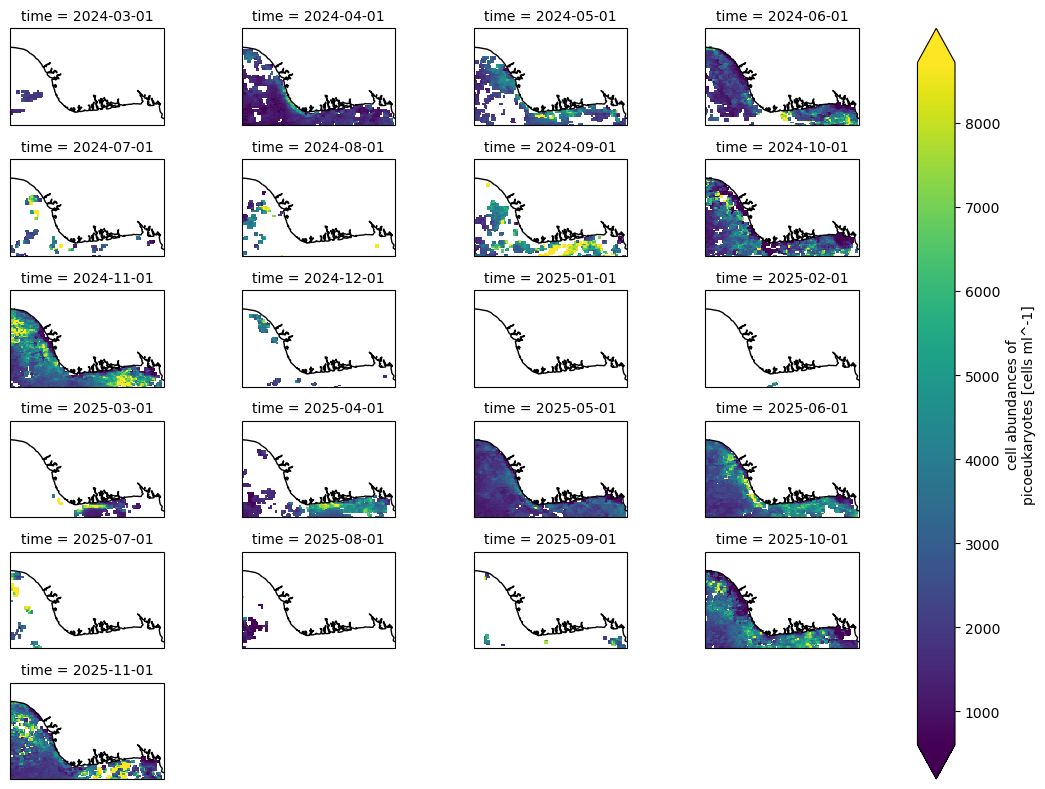

In [33]:
#caution, use larger memory to avoidcrash
import matplotlib.pyplot as plt

ndvi = ds1["picoeuk_moana"].sel(
    lat=slice(7, 3), 
    lon=slice(3, 9),
    time=slice("2024-03-01", "2025-12-30") #WHEN THIS CHANGED, ALSO CHANGE THE OUTPUT NAME BELOW
)

import cartopy.crs as ccrs
ndvi_plot=ndvi.plot(
    col="time",            # one panel per month
    col_wrap=4,            # 4 columns per row
    #vmin=0.7,
    #vmax=0.8,
    robust=True,           # ignore outliers for color scale
    figsize=(12, 8),
    subplot_kws={"projection": ccrs.PlateCarree()},
    transform=ccrs.PlateCarree()
)

for ax in ndvi_plot.axes.flat:
    ax.set_extent(
        [3.956111, 9.040000, 3.856667, 7.049167],
        crs=ccrs.PlateCarree()
    )
    ax.coastlines()

#plt.savefig("2024_timeseries2.png") #DONT FORGET TO CHANGE THIS